# A comparison of clustering algorithms

As part of the Multi-Armed Bandit approach, an unsupervised method is needed to seperate the data into subregions which are "similar" in some way, to be explored or exploited (these are the "arms"). This is a clustering problem. A particular constraint here is that the number of clusters can not be known ahead of time. Furthermore, in the fraud case, we expect significant class imbalance, so an algorithm that can handle clusters of varying sizes is most appropriate. 

We have examined a few standard clustering algorithms, and made two attempts at custom solutions, with one ("DBShift") turning out to be very applicable to our problem. This notebook provides a short overview of how the different clustering algorithms behave on various toy problems that we are working with. 

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
from sklearn.cluster import MeanShift, DBSCAN
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import olac

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (10,4)

## Generate data

Generate some data from the various toy problems: Roving Balls, Popping Clusters, Satellites, and a 2D random walk.

In [4]:
rb = np.array(list(olac.data_generators.roving_balls(steps=1000, period=3000)))[:,:-1]
pc = np.array(list(olac.data_generators.cluster_generator(n_points=1000, cluster_width=65)))[:,:-1]
sa = np.array(list(olac.data_generators.satellites(n_points=1000, contamination=0.1)))[:,:-1]
rw1 = np.array(list(olac.data_generators.rand_walk(steps=1000)))
rw2 = np.array(list(olac.data_generators.rand_walk(steps=1000)))
rw = np.hstack([rw1, rw2])

/Users/johnpaton/jads/olac/olac/utils.py:53: UserWarning: The 'utils.rotation_matrix' method is deprecated, use maths.rotation_matrix(theta: float) instead
  warnings.warn("The 'utils.rotation_matrix' method is deprecated, "


In [5]:
datasets = [rb, pc, sa, rw]
names = ['Roving Balls', 'Popping Clusters', 'Satellites', 'Random Walk']

The datasets look like this:

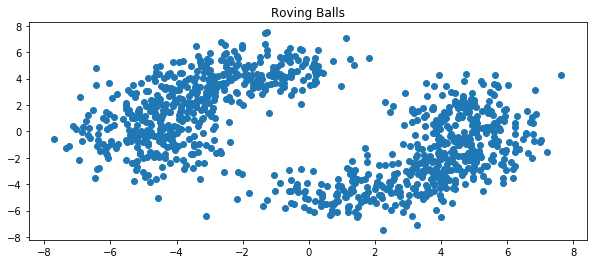

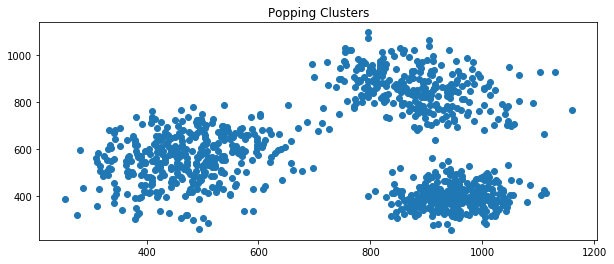

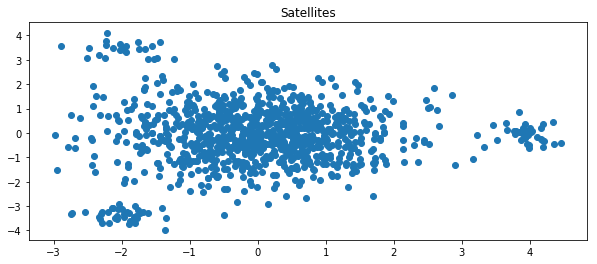

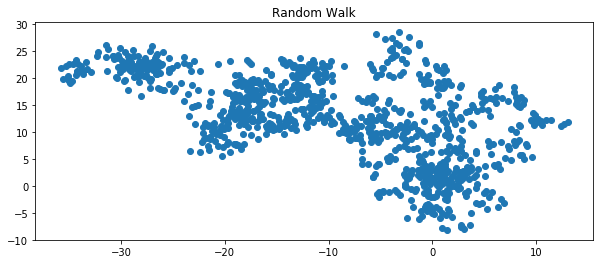

In [6]:
for i, ds in enumerate(datasets):
    plt.scatter(*ds.T)
    plt.title(names[i])
    plt.show()

## Mean Shift

Mean Shift clustering works by starting with a grid of points and moving them towards the mean of the datapoints in a *bandwidth* around each point. This means that different starting points can converge to the same location and then move together. Once the starting points stop converging, the unique points are taken as cluster centers. 

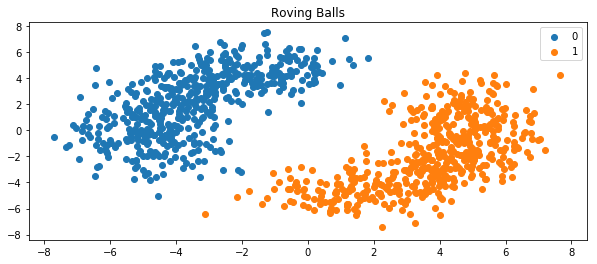

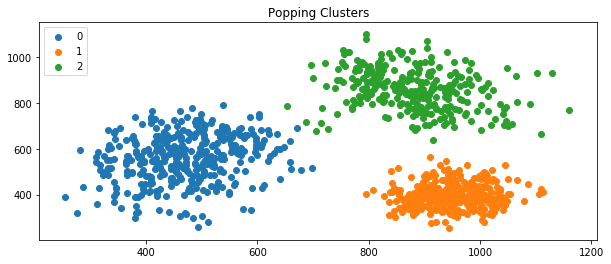

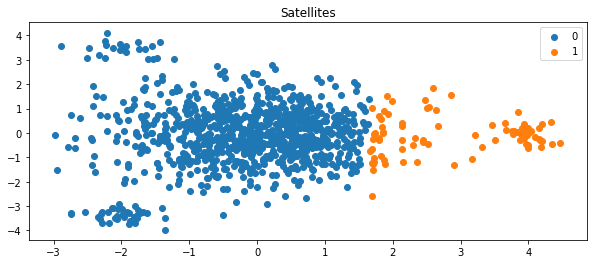

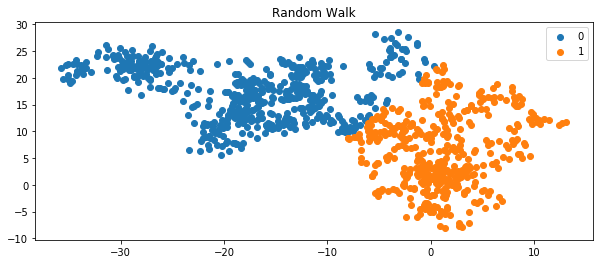

In [7]:
for i, ds in enumerate(datasets):
    clf = MeanShift(cluster_all=True)
    clusters = clf.fit_predict(ds)
    
    for c in np.unique(clusters):
        plt.scatter(*ds[clusters==c].T, label=str(c))
    
    plt.title(names[i])
    plt.legend()
    plt.show()

## DBSCAN

DBSCAN is a density-based clustering algorithm that starts with a random point. If the point has enough close by neighbors, these are globbed into the cluster. If those points have enough neighbors, those neighbors are also absorbed. If there are no more close by neighbors, another unclustered point is chosen and the process repeats. Interestingly, points with no close neighbors are left as outliers, and are not assigned to any cluster (labelled `-1` below). This is useful for us, as we expect some outliers to be fraud cases.

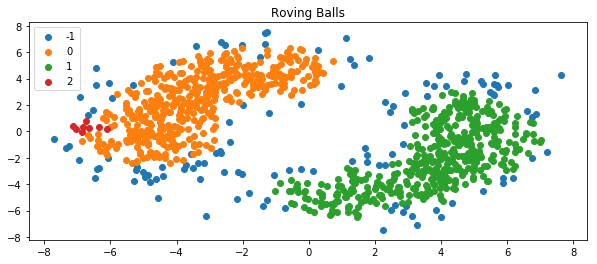

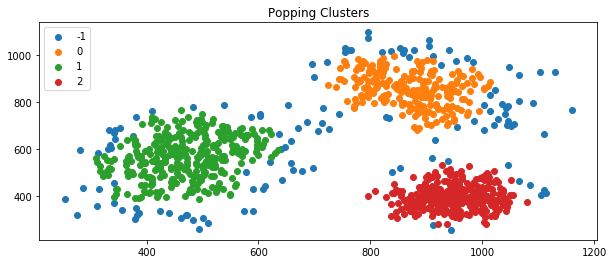

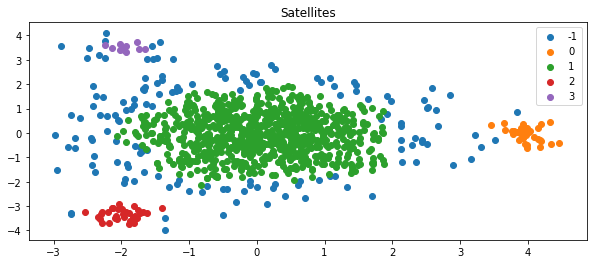

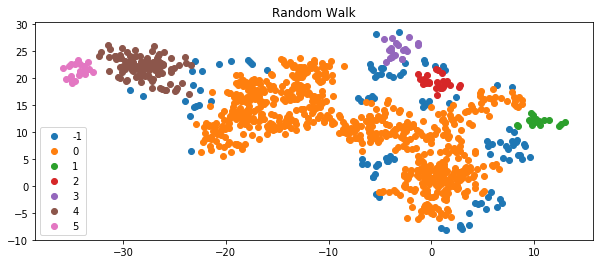

In [8]:
for i, ds in enumerate(datasets):
    eps = (ds.max(axis=0) - ds.min(axis=0)).mean()/25
    m = ds.shape[0]//100
    clusters = DBSCAN(eps=eps, min_samples=m).fit_predict(ds)
    
    for c in np.unique(clusters):
        plt.scatter(*ds[clusters==c].T, label=str(c))
        
    plt.title(names[i])
    plt.legend()
    plt.show()

## DBShift

We decided to combine these methods into DBShift. First DBSCAN is used to identify big, contiguous clusters. Then Mean Shift is applied to the remaining outliers, to group them into similar groups. This allows for special treatment of outliers, while still breaking them up into different regions of interest. We label the main clusters `0,1,2...` and the outlier clusters `-1,-2,...`

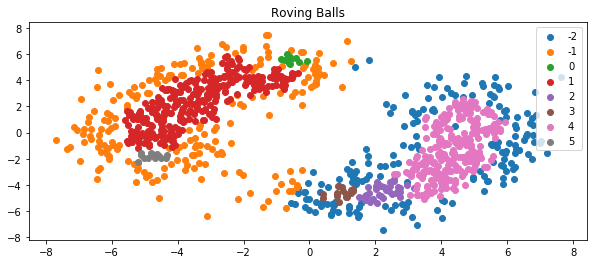

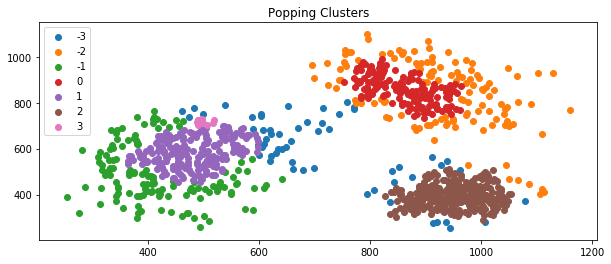

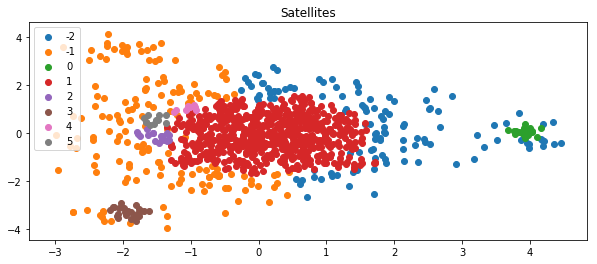

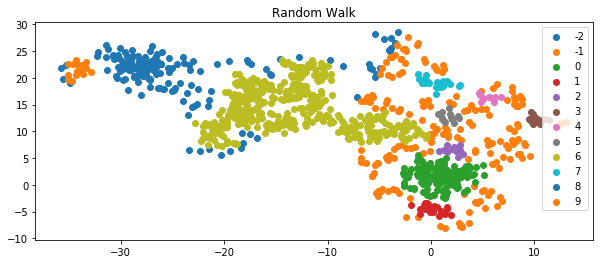

In [9]:
for i, ds in enumerate(datasets):
    clf = olac.models.DBShift()
    clusters = clf.fit_predict(ds)
    
    for c in np.unique(clusters):
        plt.scatter(*ds[clusters==c].T, label=str(c))
        
    plt.title(names[i])
    plt.legend()
    plt.show()

## Hierarchical Mean Shift

We also experimented with further clustering the biggest clusters from mean shift based on some criteria. This turned out to be both very slow, and very sensitive to the hyperparameters, so we did not end up using this model. We leave it here for posterity.

In [10]:
def hierarchical_fit(X, min_clust_recurse_size=None, *args, **kwargs):
    
    if min_clust_recurse_size is None:
        min_clust_recurse_size = X.shape[0] // 100
    
#     print(len(X))
    clusters = MeanShift(*args, **kwargs).fit_predict(X)
    unique = np.unique(clusters)
    n = unique.shape[0]
    
    if n == 1:
        return clusters
    
    for c in unique:
        cond = clusters==c
        
        if cond.sum() <= min_clust_recurse_size:
            continue 
    
        try:
            new_clusters = hierarchical_fit(X[cond], min_clust_recurse_size, *args, **kwargs)
        except ValueError:
            continue 
            
        new_clusters += clusters.max() + 1
        clusters[cond] = new_clusters
    
    return clusters - clusters.min()

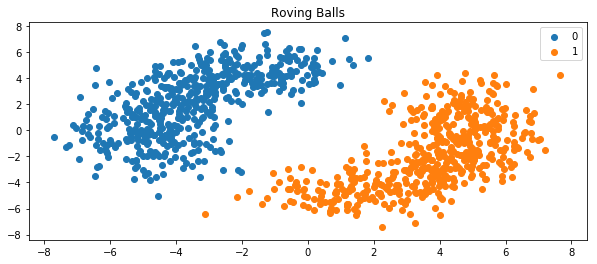

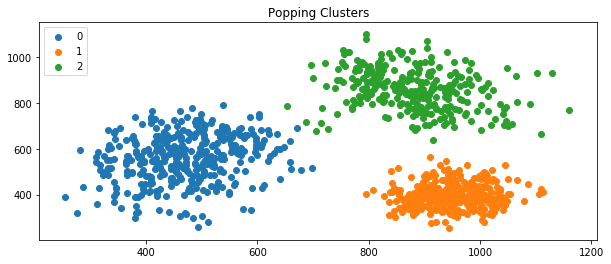

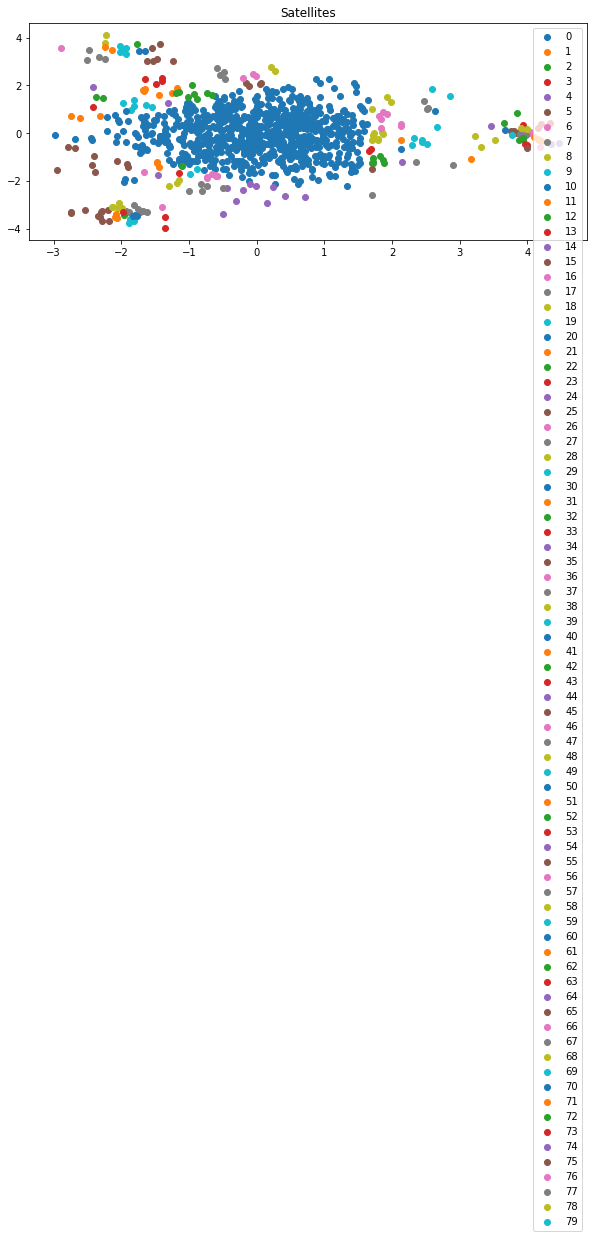

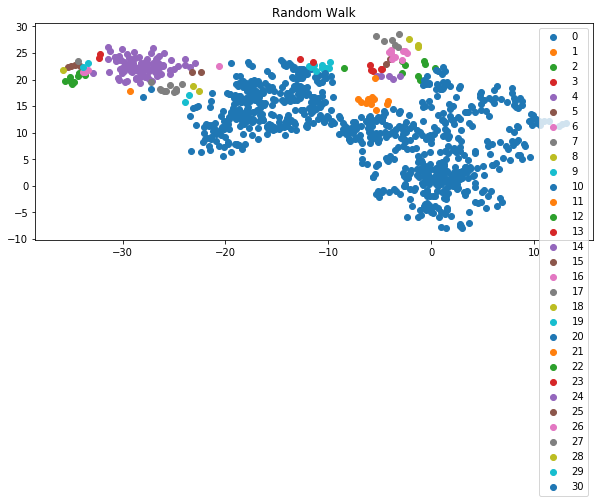

In [11]:
for i, ds in enumerate(datasets):
    clusters = hierarchical_fit(ds)
    
    for c in np.unique(clusters):
        try:
            plt.scatter(*ds[clusters==c].T, label=str(c))
        except IndexError:
            pass
    
    plt.title(names[i])
    plt.legend()
    plt.show()